<a href="https://colab.research.google.com/github/humairahs/UNet-for-hippocampus-MRI-segmentation/blob/main/Basic_UNet_segmentation_hippocampus_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ABOUT**
Alzheimer disease refers to a condition related to brain where brain cells are dead and can result in various issues, such as dementia and cognitive decline and it is associated with certain part of the brain, namely hippocampus [3]. By performing image segmentation and analysis of hippocampus, early detection of Alzheimer is possible. However, traditional way to segment image is dependant on the clinicians and is not accurate [4]. With the emergence of artificial intelligence as well as computer-aided technology, it opens up the possibility of new ways to perform image segmentation. This research aims to experiment to create an automatic segmentation system for hippocampus gland region. Hopefully, this system can support clinicians in early detection of Alzheimer by providing accurate segmentation, offering time and resource efficiency.

***> DESCRIPTION OF TASK:***
 To create a method for automatic segmentation of hippocampus glands based on MRI slices using U-Net architecture.

***> DESCRIPTION OF DATASET:***
The dataset used in this research is obtained from research conducted by Boccardi et al.[1], and accessed through Kaggle platform [2].
The dataset contains MRI from 135 Alzheimer patients, as well as their corresponding mask of hippocampus glands, done by using Hippocampal Harmonized Protocols (HHP) with a slice thickness of 1.2 mm in sagittal orientation [1]

***> METHODS:***
This work will use U-Net CNN architecture to perform the segmentation, with the flow is as follows:
*   Data collection, cleaning & preprocessing
*   Model creation & training
*   Model testing
*   Best model selection

***REFERENCES:***
1.   M. Boccardi, M. Bocchetta, R. Ganzola, N. Robitaille, A. Redolfi, S. Duchesne, et al. Operationalizing protocol differences for EADC-ADNI manual hippocampal segmentation. Alzheimers Dement. 11: 2015; 184–194
2.   Saber Malekzadeh. (2019). MRI Hippocampus Segmentation [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/400588
3. Balasundaram A, Srinivasan S, Prasad A, Malik J, Kumar A. Hippocampus Segmentation-Based Alzheimer's Disease Diagnosis and Classification of MRI Images. Arab J Sci Eng. 2023 Jan 3:1-17. doi: 10.1007/s13369-022-07538-2. Epub ahead of print. PMID: 36619218; PMCID: PMC9810248.
4. Hazarika RA, Maji AK, Syiem R, Sur SN, Kandar D. Hippocampus Segmentation Using U-Net Convolutional Network from Brain Magnetic Resonance Imaging (MRI). J Digit Imaging. 2022 Aug;35(4):893-909. doi: 10.1007/s10278-022-00613-y. Epub 2022 Mar 18. PMID: 35304675; PMCID: PMC9485390.




# Import libraries & data

In [1]:
# Importing necessary libraries for the task

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from pathlib import Path
from tensorflow import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import (Conv2D, MaxPool2D, Flatten, Dense, LeakyReLU, Softmax, Input, BatchNormalization, MaxPooling2D, Conv2DTranspose, Dropout,
                            UpSampling2D, concatenate, Lambda)
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras import layers, Model
from tensorflow.keras import backend as K


In [2]:
# Data saved in personal drive mounted to be worked on in this colabolatory
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
!unzip -q '/content/drive/MyDrive/EMMBIOME/dataset/sabermalekmrihs.zip' -d '/content/dataset/'
path_folder = '/content/dataset/'

In [4]:
# The images and masks are within label & original folder respectively

label_path = '/content/dataset/label/'
image_path = '/content/dataset/original/'

label_list_path = list(Path(label_path).glob(r"**/*.jpg"))  #List of path of all masks
image_list_path = list(Path(image_path).glob(r"**/*.jpg"))  #List of path of all images

# all data
len(image_list_path), len(label_list_path)

(25515, 50841)

## Handling correct pairs of img & mask

In [ ]:
# Categorize label_list_path to label_list_left and label_list_right

label_list_left = []
label_list_right = []

for label_path in label_list_path:
  path = str(label_path)
  if path[-9] == 'L':
    label_list_left.append(path)
  elif path[-9] == 'R':
    label_list_right.append(path)

In [ ]:
image_list = [str(a) for a in image_list_path]

In [ ]:
'''
The mask is supposed to consist of left (L) and right (R) part of hippocampus segmentation. However, some masks do not have
corresponding part. To ensure that each image has complete mask, and all masks correspond to an image, we filter it & keep
only those having complete pieces.
'''

def extract_key(string):
  s = string.split('/')[-1]
  parts = s.split('_')
  key = '_'.join(parts[:5] + parts[-1:])
  return key

dict_L = {extract_key(s): s for s in label_list_left}
dict_R = {extract_key(s): s for s in label_list_right}
dict_image = {extract_key(s): s for s in image_list}

common_keys = set(dict_L.keys()) & set(dict_R.keys()) & set(dict_image.keys())

filtered_label_L = [dict_L[key] for key in common_keys]
filtered_label_R = [dict_R[key] for key in common_keys]
filtered_list_image = [dict_image[key] for key in common_keys]

filtered_label_L.sort()
filtered_label_R.sort()
filtered_list_image.sort()

m = 5000
filtered_label_L[m], filtered_label_R[m], filtered_list_image[m]

('/content/dataset/label/100label/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_L/ADNI_007_S_4387_269929_L_087.jpg',
 '/content/dataset/label/100label/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_R/ADNI_007_S_4387_269929_R_087.jpg',
 '/content/dataset/original/100/ADNI_007_S_4387_269929_ACPC/ADNI_007_S_4387_269929_ACPC_087.jpg')

# Helper functions


In [3]:
def padding_image(img):
  top = 12
  bottom = 11
  left = 30
  right = 29

  padded_img = np.pad(img, ((top, bottom), (left, right)), 'constant', constant_values = 0)
  return padded_img

In [4]:
# def crop_image(image):
#     height, width = image.shape     #(233, 197)
#     newshape = 128
#     center_y = int(np.ceil(height/2))
#     center_x = int(np.ceil(width/2))
#     start_y = center_y - newshape//2
#     end_y = center_y + newshape//2
#     start_x = center_x - newshape//2
#     end_x = center_x + newshape//2
#     cropped_image = image[start_y:end_y, start_x:end_x]
#     return cropped_image

In [5]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 10,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True
)

In [6]:
def dice_coef(y, y_pred):
    intersect = np.sum(y_pred*y)
    total_sum = np.sum(y_pred) + np.sum(y)
    dice_coef = np.mean(2*intersect/total_sum)
    return dice_coef

def iou_score(y, y_pred):
    pred_mask = y_pred_thresholded
    groundtruth_mask = y_test
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return iou

# Load mask

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
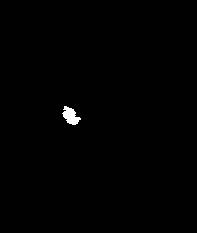

In [ ]:
# Sample of mask

image = cv2.imread(filtered_label_L[70])
image

In [ ]:
# Concatenating L and R mask, then each image will have 1 mask only

list_concat = []
for i in range(len(filtered_label_L)):
  left = cv2.imread(filtered_label_L[i], cv2.IMREAD_GRAYSCALE)
  img_left = (left/255 > 0.5).astype(np.uint8)*255
  right = cv2.imread(filtered_label_R[i], cv2.IMREAD_GRAYSCALE)
  img_right = (right/255 > 0.5).astype(np.uint8)*255
  concat = cv2.addWeighted(img_left, 0.5, img_right, 0.5, 0)
  img_concat = (concat/255 > 0.5).astype(np.uint8)

  padded_img_concat = padding_image(img_concat)
  list_concat.append(padded_img_concat)
label_concat = np.array(list_concat)

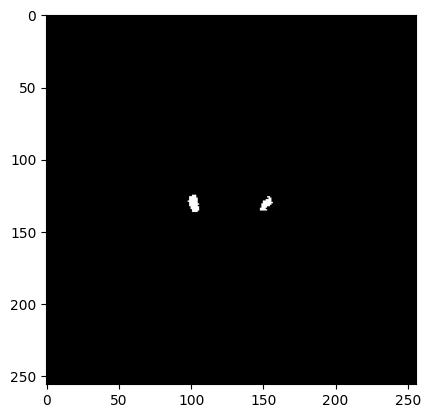

In [ ]:
plt.imshow(label_concat[67], cmap='gray');

# Load original image


In [ ]:
# The original image is not in square shape, so we pad it. The final size of image is (256,256)

list_image = []
for path in filtered_list_image:
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

  padded_img = padding_image(img)
  list_image.append(padded_img)
images = np.array(list_image)

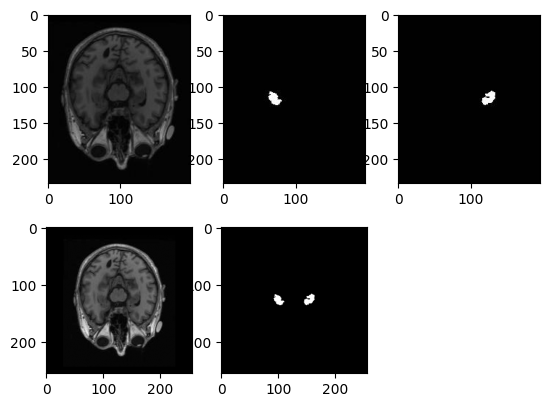

In [ ]:
# Display sample of data index-70 of its original & new shape, and mask before and after concatenation

idx = 70
plt.subplot(2,3,1)
plt.imshow(cv2.imread(filtered_list_image[idx]))
plt.subplot(2,3,2)
plt.imshow(cv2.imread(filtered_label_L[idx]))
plt.subplot(2,3,3)
plt.imshow(cv2.imread(filtered_label_R[idx]))
plt.subplot(2,3,4)
plt.imshow(images[idx], cmap='gray')
plt.subplot(2,3,5)
plt.imshow(label_concat[idx], cmap='gray');

In [ ]:
# Original size of dataset after being cleaned: 25326 images & masks
images.shape, label_concat.shape

((25326, 256, 256), (25326, 256, 256))

In [ ]:
# Due to limited computational resource, data is reduced. We only select the equal number of data of those having segmented part
# and not (fully black in mask)


idx_bw = np.where([len(np.unique(img))==2 for img in label_concat])[0]
idx_black = np.where([len(np.unique(img))==1 for img in label_concat])[0]
idx_black_selected = np.random.choice(idx_black, size=len(idx_bw)-1, replace=False)
selected_idx = np.concatenate((idx_bw, idx_black_selected))

selected_mask = label_concat[selected_idx]
selected_image = images[selected_idx]

In [ ]:
selected_mask.shape, selected_image.shape, selected_image.dtype

((8047, 256, 256), (8047, 256, 256), dtype('uint8'))

In [ ]:
# np.save('/content/drive/MyDrive/EMMBIOME/dataset/selected_image.npy', selected_image)
# np.save('/content/drive/MyDrive/EMMBIOME/dataset/selected_mask.npy', selected_mask)

# Preprocess original image

In [18]:
selected_image = np.load('/content/drive/MyDrive/EMMBIOME/dataset/selected_image.npy')
selected_mask = np.load('/content/drive/MyDrive/EMMBIOME/dataset/selected_mask.npy')

# selected_image = np.load('/content/drive/MyDrive/EMMBIOME/dataset/selected_image_smaller.npy')
# selected_mask = np.load('/content/drive/MyDrive/EMMBIOME/dataset/selected_mask_smaller.npy')

selected_mask.shape, selected_image.shape, selected_image.dtype

((8048, 256, 256), (8048, 256, 256), dtype('uint8'))

In [19]:
# CLAHE
def clahe(img):
  return cv2.createCLAHE().apply(img)


# Sharpening to enhance the edge/boundaries within objects in image
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
def sharpen(img):
  return cv2.filter2D(img, ddepth=-1, kernel=kernel)

## **Histogram equalization*

In [20]:
# Histogram equalization

def plot_histogram(img):
  plt.hist(img.flatten(), 256, range=[0,256], color='r')
  plt.xlim([0,256])
  plt.xlabel('Intensity')
  plt.ylabel('Number of pixels')
  plt.show()

def plot_histeq(img):
  img = histeq(img)
  plt.hist(img.flatten(), 256, range=[0,256], color='r')
  plt.xlim([0,256])
  plt.xlabel('Intensity')
  plt.ylabel('Number of pixels')
  plt.show()

def histeq(img):
  return cv2.equalizeHist(img)

def clahe(img):
  return cv2.createCLAHE().apply(img)


## **Smoothing*

In [21]:
# Bilinear smoothing to preserve edge

def smoothing(img, diameter=3):
  return cv2.bilateralFilter(img,diameter,75,75)

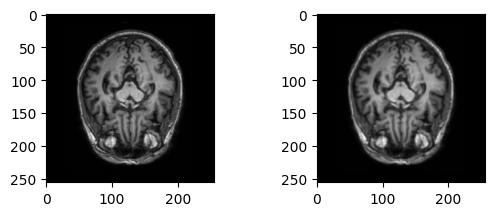

In [22]:
idx = 70

plt.subplot(2,2,1)
plt.imshow(selected_image[idx], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(smoothing(selected_image[idx]), cmap='gray')   # bilateral-smoothed image
plt.show()

## *Combined preprocessing methods*
Perform trial-error to find the best combination of preprocessing methods for the model later. For example, we started by trying to train model with original data, then by histogram equalized data, and until some combinations of methods to get some variations of preprocessed data.

In [23]:
preprocessed_image = np.array([sharpen(clahe(img)) for img in selected_image])

# Prepare data for model

In [24]:
x = np.expand_dims(tf.keras.utils.normalize(selected_image), 3)
y = np.expand_dims(selected_mask, 3)

In [25]:
x.dtype, y.shape

(dtype('float64'), (8048, 256, 256, 1))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 42)

print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Set Shape: {X_test.shape}, {y_test.shape}")

Training Set Shape: (6840, 256, 256, 1), (6840, 256, 256, 1)
Test Set Shape: (1208, 256, 256, 1), (1208, 256, 256, 1)


## helpers

In [27]:
def metric_iou(y, y_pred):
    y = tf.cast(y, tf.float32)  # Ensure that y is float32
    y_pred_thresholded = tf.cast(y_pred > 0.5, tf.float32)

    intersection = K.sum(y * y_pred_thresholded)
    union = K.sum(y) + K.sum(y_pred_thresholded) - intersection

    iou_score = intersection / (union + K.epsilon())
    return iou_score

def metric_dice(y, y_pred):
    y = tf.cast(y, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = tf.reduce_sum(y * y_pred, axis=[1, 2, 3])
    sum_ = tf.reduce_sum(y, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2.0 * intersection + K.epsilon()) / (sum_ + K.epsilon()))

    return dice


def plot_train(history):
  plt.figure(figsize=(12, 5))
  # Accuracy plot
  plt.subplot(1, 2, 1)
  plt.plot(history.history['metric_iou'], label='Training IoU', color='blue')
  plt.title('Model IoU Score')
  plt.xlabel('Epoch')
  plt.ylabel('IoU score')
  plt.legend(loc='lower right')

  # Loss plot
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Training Loss', color='red')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')
  plt.show()

def test_model(model, X_test, y_test, threshold=0.5):
  y_pred=model.predict(X_test)
  y_pred_thresholded = y_pred > threshold

  intersection = np.logical_and(y_test, y_pred_thresholded)
  union = np.logical_or(y_test, y_pred_thresholded)
  iou = np.sum(intersection) / np.sum(union)
  dice = dice_coef(y_test, y_pred_thresholded)

  print("IoU score: {0}\t, Dice coefficient: {1}".format(iou, dice))

  for i in range(1, 5):
    test_img_number = random.randint(0, len(X_test)-1)
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
    plt.figure(figsize=(16, 8))
    plt.subplot(2,3,1)
    plt.title('Original test image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(2,3,2)
    plt.title('Ground truth')
    plt.imshow(ground_truth[:,:,0], cmap='gray')
    plt.subplot(2,3,3)
    plt.title('U-Net prediction')
    plt.imshow(prediction, cmap='gray')

def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# def weighted_bce_dice_loss(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
#     averaged_mask = K.pool2d(
#         y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
#     weight = K.ones_like(averaged_mask)
#     w0 = K.sum(weight)
#     weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
#     w1 = K.sum(weight)
#     weight *= (w0 / w1)
#     loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
#     return loss


# earlystopping = EarlyStopping(
#     monitor = 'val_loss',
#     patience = 10,
#     verbose = 1,
#     mode = 'min',
#     restore_best_weights = True
# )

In [28]:
EPOCH = 100
BATCH_SIZE = 64

# UNet Model

In [29]:
class UNet1:
    def __init__(
                self,
                base_filters=16,
                dropout_rate=0.1,
                activation='relu',
                kernel_initializer='he_normal',
                use_batchnorm=True):

        self.base_filters = base_filters
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.kernel_initializer = kernel_initializer
        self.use_batchnorm = use_batchnorm

    def build_unet(self):
        def conv_block(x, filters, dropout_rate=self.dropout_rate):
            x = layers.Conv2D(filters, (3, 3), kernel_initializer=self.kernel_initializer, padding='same')(x)
            x = layers.Activation(self.activation)(x)   #batchnorm after activation layer gives better performance
            if self.use_batchnorm:
                x = layers.BatchNormalization()(x)
            # x = layers.Activation(self.activation)(x)

            x = layers.Conv2D(filters, (3, 3), kernel_initializer=self.kernel_initializer, padding='same')(x)
            x = layers.Activation(self.activation)(x)
            if self.use_batchnorm:
                x = layers.BatchNormalization()(x)
            # x = layers.Activation(self.activation)(x)
            if dropout_rate:
                x = layers.Dropout(dropout_rate)(x)
            return x

        def up_block(x, skip, filters, dropout_rate=self.dropout_rate):
            x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
            x = layers.Concatenate()([x, skip])
            x = layers.Dropout(dropout_rate)(x)
            x = conv_block(x, filters)
            return x

        inputs = layers.Input(shape=(x.shape[1], x.shape[2], x.shape[3]))
        f = self.base_filters

        # Encoder
        c1 = conv_block(inputs, f)
        p1 = layers.MaxPooling2D((2, 2))(c1)

        c2 = conv_block(p1, f * 2)
        p2 = layers.MaxPooling2D((2, 2))(c2)

        c3 = conv_block(p2, f * 4)
        p3 = layers.MaxPooling2D((2, 2))(c3)

        c4 = conv_block(p3, f * 8)
        p4 = layers.MaxPooling2D((2, 2))(c4)

        c5 = conv_block(p4, f * 16)
        p5 = layers.MaxPooling2D((2, 2))(c5)

        # Bottleneck
        c6 = conv_block(p5, f * 32)

        # Decoder
        c7 = up_block(c6, c5, f * 16)
        c8 = up_block(c7, c4, f * 8)
        c9 = up_block(c8, c3, f * 4)
        c10 = up_block(c9, c2, f * 2)
        c11 = up_block(c10, c1, f)

        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
        model = Model(inputs=inputs, outputs=outputs)
        return model

unet = UNet1(base_filters=16)


In [30]:
model = unet.build_unet()
# model.summary()

In [31]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
               loss = 'binary_crossentropy',
               metrics = [metric_iou])
history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    epochs = EPOCH,
                    shuffle = True)


Epoch 1/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 114s 505ms/step - loss: 0.7201 - metric_iou: 0.0013
Epoch 2/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.5384 - metric_iou: 0.0016
Epoch 3/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.3775 - metric_iou: 0.0012
Epoch 4/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.2441 - metric_iou: 5.2281e-04
Epoch 5/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.1555 - metric_iou: 0.0015
Epoch 6/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.1016 - metric_iou: 0.0787
Epoch 7/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0691 - metric_iou: 0.4020
Epoch 8/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0492 - metric_iou: 0.5125
Epoch 9/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0363 - metric_iou: 0.5564
Epoch 10/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0279 - metric_iou: 0.5775
Epoch 11/200
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0222 - metric_iou

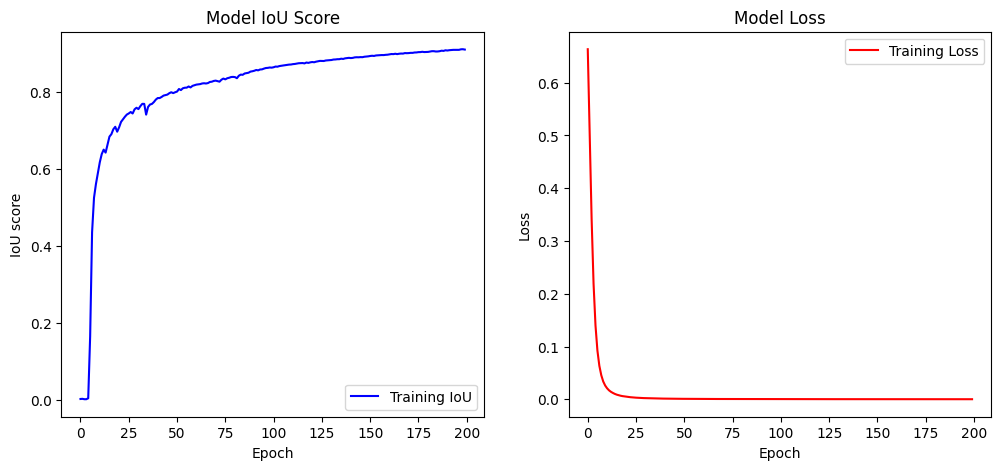

In [32]:
plot_train(history)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
IoU score: 0.8201495311660952	, Dice coefficient: 0.9011891793754538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


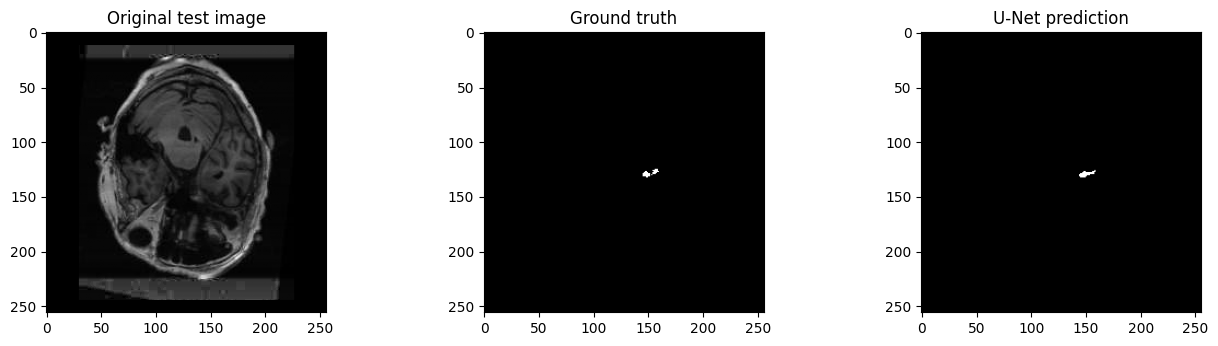

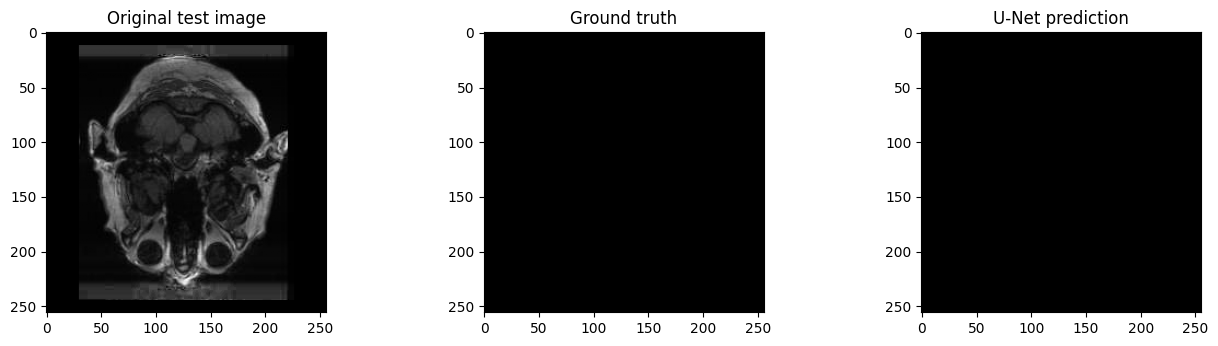

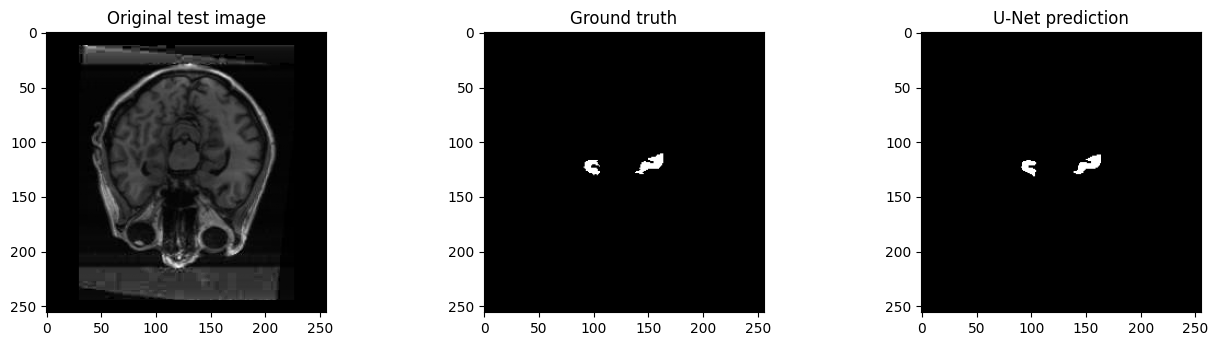

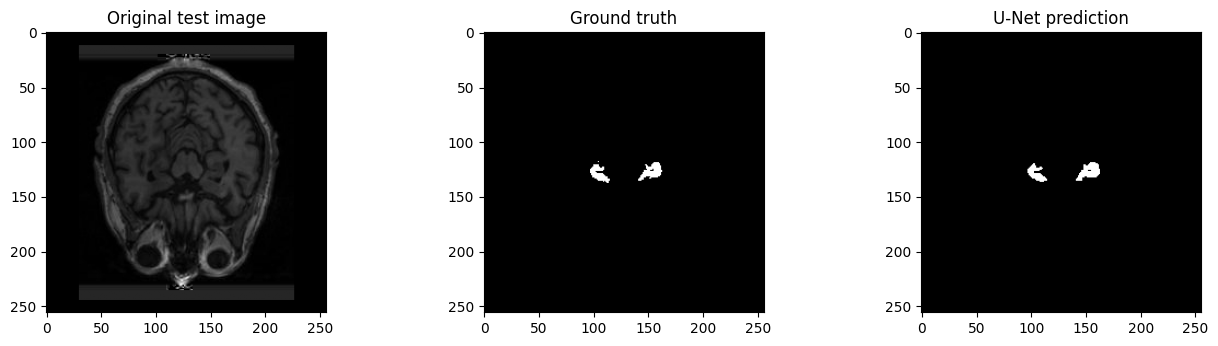

In [35]:
test_model(model, X_test, y_test, threshold=0.5)

## Test different loss

In [37]:
def bce_dice_loss(y_true, y_pred, bce_weight=0.5, smooth=1e-6):         # Gives better result to model (use smaller dataset)
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    dice_loss = 1 - dice
    return bce_weight * bce + (1 - bce_weight) * dice_loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [41]:
model4 = unet.build_unet()
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
               loss = bce_dice_loss,
               metrics = [metric_iou])
history4 = model4.fit(X_train, y_train,
                    batch_size = 32,
                    verbose = 1,
                    epochs = 100,
                    shuffle = True)


Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 92s 200ms/step - loss: 0.8273 - metric_iou: 0.0014
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.6522 - metric_iou: 4.6414e-06
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.5598 - metric_iou: 0.0582
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.5006 - metric_iou: 0.4118
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.3992 - metric_iou: 0.5505
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.1568 - metric_iou: 0.6764
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.1012 - metric_iou: 0.7177
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0903 - metric_iou: 0.7288
Epoch 9/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0852 - metric_iou: 0.7349
Epoch 10/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.0804 - metric_iou: 0.7439
Epoch 11/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0776 - metric_iou:

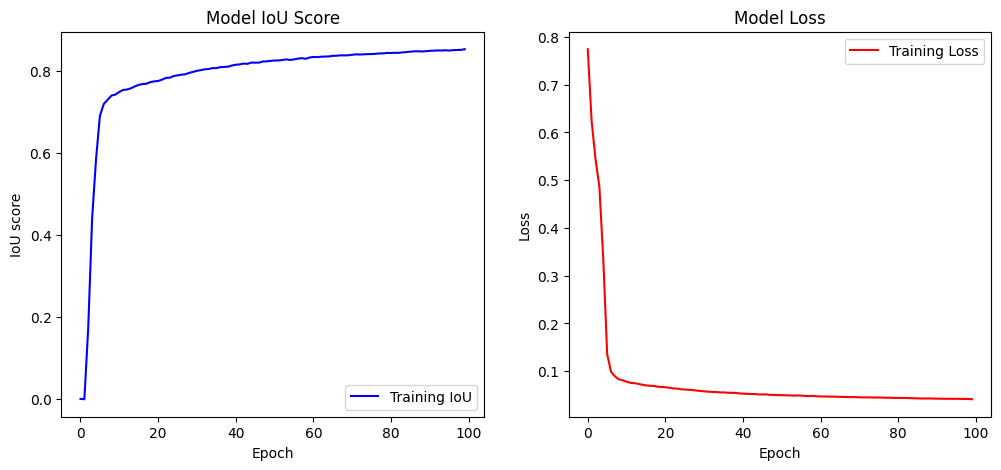

In [42]:
plot_train(history4)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step
IoU score: 0.812303731459541	, Dice coefficient: 0.8964322230968991
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


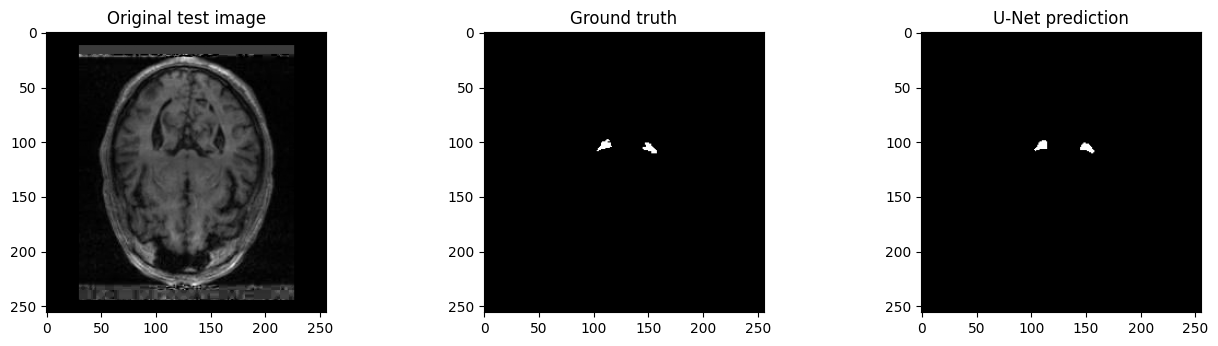

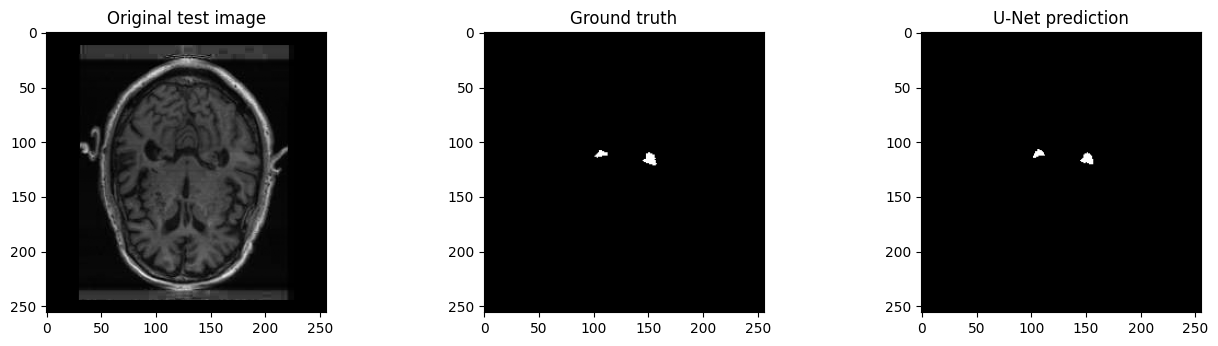

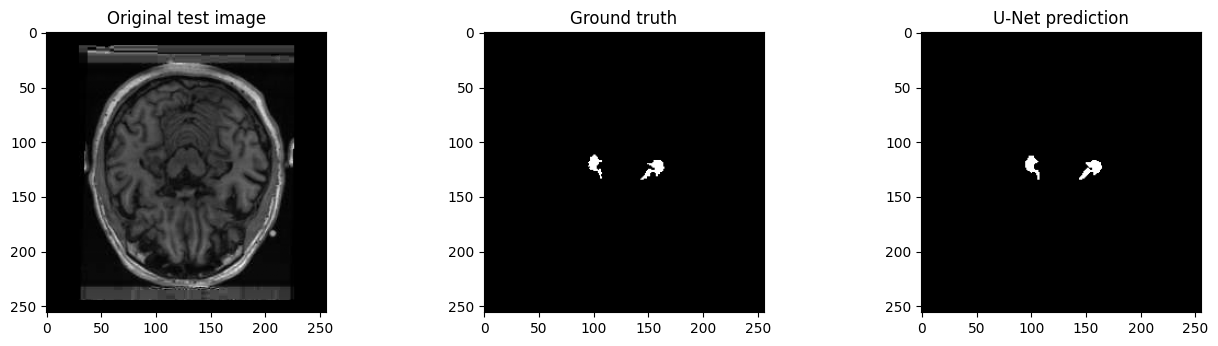

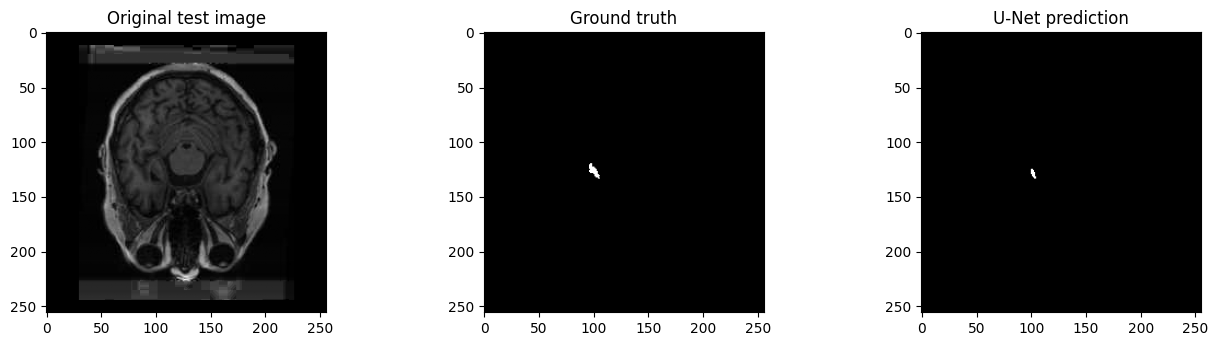

In [43]:
test_model(model4, X_test, y_test, threshold=0.5)

# NOTES
* Although we have quite large size of the original dataset, due to resource limitation, we have to reduce its size. However, the result seems promising given 1/3 of the original data
* Final modelused fewer blocks than previously tried models, yet gave the best result (all without batch normalization layer). Num of blocks: 5 in encoder & decoder, 1 in bottleneck
* Addition of batch normalization layer boosts the performance.
* Model performs better with preprocessed images than with original images. Best combination of preprocessing steps are Contrast Limited Adaptive Histogram Equalization (CLAHE) and sharpening.
* Bce dice loss (seems to) give better result than bce. *try using the same epoch, bcs prev trial only used less epoch in bce dice loss.
* Smaller batch size, the better the learning process despite longer training time.

What's next:
* Implement Attention UNet
* Ensure patient level split for train & test
* More post processing, apart from adjusting threshold
